In [1]:
!pip install transformers -q

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertForSequenceClassification
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from IPython.display import clear_output

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla P100-PCIE-16GB GPUs


## IDEAS:

- M-BERT
- https://huggingface.co/sismetanin/xlm_roberta_large-ru-sentiment-rusentiment
- other models

In [51]:
model_name = 'DeepPavlov/rubert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

tokenizer_config.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

XLMRobertaTokenizerFast(name_or_path='sismetanin/xlm_roberta_large-ru-sentiment-rusentiment', vocab_size=250002, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250001: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [53]:
from typing import List, Tuple


class EntityDataset(Dataset):
    def __init__(self,
                 texts: List[str],
                 labels: List[int],
                 entities: List[List[Tuple[int, int, int]]],
                 tokenizer,
                 max_len: int = 512,  # Органичение на длину входной последовательности
                 shifts: int = 256):
        
        self.samples = []
        
        for i, text in enumerate(texts):
            _, start, end = entities[i]
            entity_text = text[start:end]
            
            # Структура токенизированного ввода: [CLS] + пресложение + [SEP] + сущность + [SEP] + конец предложения + [EOS]
            # Для каждой сущности идём shift символов вправо и влево и обрезаем до пробела,
            # чтобы окно с сущностью в центре получалось
            pre_entity_text = text[:start]
            idx_space_begin = pre_entity_text.find(' ', start - shifts)
            pre_entity_text = pre_entity_text[idx_space_begin + 1:]
            
            post_entity_text = text[end:]
            idx_space_end = post_entity_text.rfind(' ', 0, shifts)
            if idx_space_end == -1:
                idx_space_end = len(post_entity_text)
            post_entity_text = post_entity_text[:idx_space_end]
            
            sequence = f"{pre_entity_text} <pad> {entity_text} <pad> {post_entity_text}"

            tokenized_input = tokenizer.encode_plus(
                sequence,
                add_special_tokens=True,
                max_length=max_len,
                truncation=True,
                padding=False,
                return_tensors="pt"
            )

            input_ids = tokenized_input['input_ids'].squeeze(0)
            token_type_ids = tokenized_input['token_type_ids'].squeeze(0)
            attention_mask = tokenized_input['attention_mask'].squeeze(0)

            self.samples.append({
                "input_ids": input_ids,
                "token_type_ids": token_type_ids,
                "attention_mask": attention_mask,
                "label": labels[i],
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        return self.samples[index]

In [54]:
def pad_collate(batch):
    """Дополняем до максимальной в батче долины"""
    input_ids = [sample["input_ids"] for sample in batch]
    token_type_ids = [sample["token_type_ids"] for sample in batch]
    attention_mask = [sample["attention_mask"] for sample in batch]
    labels = [sample["label"] for sample in batch]

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    token_type_ids = torch.nn.utils.rnn.pad_sequence(token_type_ids, batch_first=True, padding_value=tokenizer.pad_token_type_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask,
        "label": torch.LongTensor(labels),
    }

In [7]:
df = pd.read_csv('/kaggle/input/gagarin-ans-v1/ans_v1.csv')  # Датасет текстов, сущностей в них и сентимента
df = df[df.score != 0]
df.score -= 1
texts = list(df['text'])
labels = list(df['score'].astype(int))
entities = list(zip(df['entity_idx'], df['start_pos'], df['end_pos']))

In [ ]:
dataset = EntityDataset(texts, labels, entities, tokenizer)

dataset_size = len(dataset)
indices = list(range(dataset_size))

# Разделяем индексы на обучающую и тестовую выборки
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Создаем подмножества датасета
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

BATCH_SIZE = 20

# Создаем DataLoader для обучающего и тестового наборов
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, collate_fn=pad_collate, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, collate_fn=pad_collate, shuffle=False)

In [42]:
val_labels = [i['label'] for i in list(val_subset)]

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Какие-то параметры для обучения :D Можно без них попробовать
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
  {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.01},
  {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
    'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)

In [1]:
def model_train(epochs=1, cnt_steps_batch=1):
    """
    cnt_steps_batch -- раз во сколько батчей делаем optimizer.step()
    (увеличивать batch_size так можно в cnt_steps_batch раз)
    """
    val_acc = []
    val_f1 = []
    train_loss_set = []

    for ep in range(epochs):
        model.train()

        for step, batch in enumerate(train_loader):
            b_input_ids = batch['input_ids'].to(device)
            b_token_type_ids = batch['token_type_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['label'].to(device)

            loss = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)
            train_loss_set.append((loss[0] / len(b_input_ids)).item())

            loss_back = loss[0] / cnt_steps_batch
            loss_back.backward()

            if (step + 1) % cnt_steps_batch == 0:
                optimizer.step()
                optimizer.zero_grad()

            clear_output(True)
            plt.plot(train_loss_set)
            plt.title(f"Training loss on epoch {ep + 1}/{epochs}")
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.show()
            print('Эпоха: accuracy, f1')
            for i in range(ep):
                print(str(i + 1) + '/' + str(epochs) + ': ' + str(val_acc[i]) + ', ' + str(val_f1[i]))

        model.eval()

        val_preds = []

        for batch in val_loader:
            b_input_ids = batch['input_ids'].to(device)
            b_token_type_ids = batch['token_type_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['label'].to(device)
            
            with torch.no_grad():
                logits = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)
            ans = logits[1].detach().to('cpu').numpy()
            for i in range(len(ans)):
                ans_ind = np.argmax(ans[i]).item()
                val_preds.append(ans_ind)

        val_acc.append(accuracy_score(val_labels, val_preds))
        val_f1.append(f1_score(val_labels, val_preds, average='macro'))
        
        if val_acc[-1] == max(val_acc):
            torch.save(model.state_dict(), f'/kaggle/working/model_{round(max(val_acc), 4)}.pth')

        print('Эпоха: accuracy, f1')
        for i in range(ep + 1):
            print(str(i + 1) + '/' + str(epochs) + ': ' + str(val_acc[i]) + ', ' + str(val_f1[i]))

In [ ]:
model_train(1)

Валидация

In [47]:
model.eval()
val_preds = []

for batch in tqdm(val_loader):
    b_input_ids = batch['input_ids'].to(device)
    b_token_type_ids = batch['token_type_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['label'].to(device)

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=b_input_mask, labels=b_labels)
    ans = logits[1].detach().to('cpu').numpy()
    for i in range(len(ans)):
        ans_ind = np.argmax(ans[i]).item()
        val_preds.append(ans_ind)

100%|██████████| 176/176 [00:05<00:00, 32.73it/s]


Accuracy: 0.6881413911060433
F1: 0.561526979795542


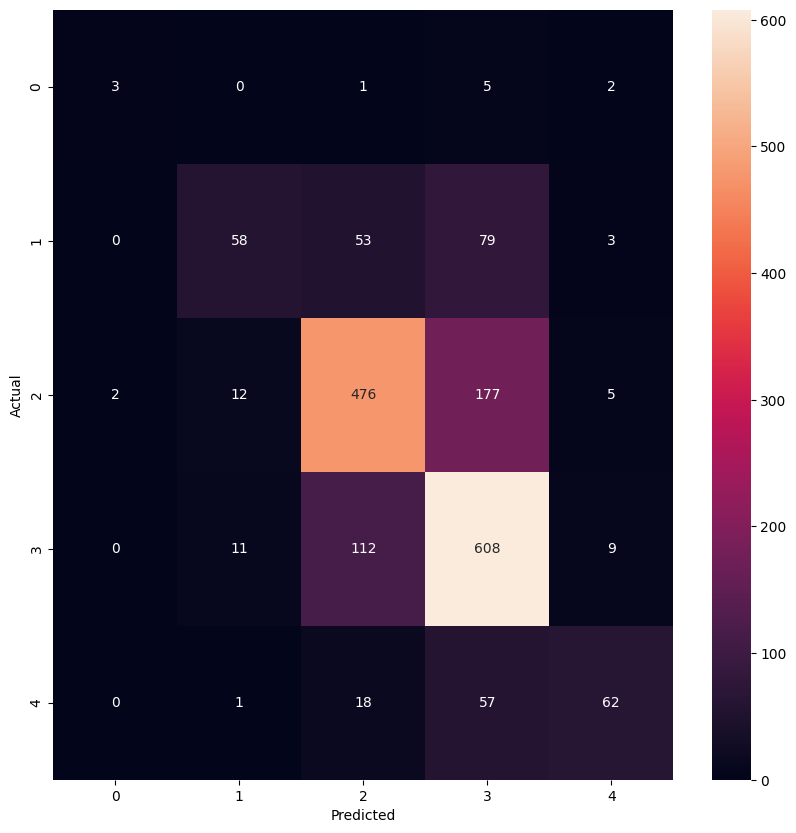

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(val_labels, val_preds))
print("F1:", f1_score(val_labels, val_preds, average='macro'))
conf_mat = confusion_matrix(val_labels, val_preds)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=range(5), yticklabels=range(5))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [22]:
torch.save(model.state_dict(), '/kaggle/working/model_final.pth')